## Import the libraries and load in the data

### Importing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import re
import itertools
import os
from collections import defaultdict
import string
from functools import partial

import nltk
from tqdm import tqdm
import spacy

import xgboost as xgb
import lightgbm as lgb

from sklearn import model_selection, ensemble, linear_model, svm
from sklearn import metrics, manifold, decomposition, tree
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

### Constants

In [ ]:
SEED = 2209
TEST_SIZE = 0.1
VOCAB_SIZE = 1500

### Loading the data

In [ ]:
qns = pd.read_csv("datasets/input_to_tagging.csv")

qns.rename(columns={'tag1':'tag','stop_words_removed_qns':'qn'}, inplace=True)

In [ ]:
qns["tag"].unique(), qns["tag"].nunique()

(array(['graph', 'array', 'string'], dtype=object), 3)

## Preprocessing

The questions will be preprocessed using the following steps,
* Removing punctuations ([] will not be removed)
* Stop words will be removed
* Lower casing
* Stop word removal
* Lemmatization 

### Removing punctuations

In [ ]:
print(f"Punctuation symbols: {string.punctuation}")

puncts = string.punctuation

idx_open = puncts.index('[')
puncts = puncts[:idx_open] + puncts[idx_open+1:]

idx_closed = puncts.index(']')
puncts = puncts[:idx_closed] + puncts[idx_closed+1:]

print(puncts)

Punctuation symbols: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
!"#$%&'()*+,-./:;<=>?@\^_`{|}~


In [ ]:
qns

,qn,tag
0,Andrew love sea that s height summer season de...,graph
1,monocarp playing Minecraft want build wall cac...,graph
2,you give n segment coordinate axis the ith seg...,array
3,Alperen strings s t initially equal he perform...,string
4,Kirill live connect undirected graph n vertex ...,graph
...,...,...
2763,give integer array num positive integer return...,array
2764,you give 0indexed array num size n consist non...,array
2765,you give integer array num integer k find maxi...,array
2766,you give 0indexed integer array cost costsi co...,array


In [ ]:
def remove_punctuation(text):
  new_text = "".join([t for t in text if t not in puncts])
  return new_text

qns['qn'] = qns['qn'].apply(lambda qn:remove_punctuation(qn))

### Lower casing the text

Lower casing the text reduces the vocabulary size and it also makes sure that two same words in different cases are not treated as different words

In [ ]:
qns['qn'] = qns['qn'].str.lower()

### Stop word removal

In [ ]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
stopwords[:10]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [ ]:
def remove_stopwords(text):
  new_text = [word for word in text.split(' ') if word not in stopwords]
  return ' '.join(new_text)

In [ ]:
qns['qn'] = qns['qn'].apply(lambda qn: remove_stopwords(qn))

### Lemmatization

In [ ]:
nltk.download('omw-1.4')
nltk.download('wordnet')
wn_lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatizer(text):
  new_text = [wn_lemmatizer.lemmatize(word) for word in text.split(' ')]
  return ' '.join(new_text)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
qns['qn'] = qns['qn'].apply(lambda qn: lemmatizer(qn))

In [ ]:
len_of_qns = qns['qn'].str.split().apply(lambda qn: len(qn))

In [ ]:
print(f"Mean length of a qn: {len_of_qns.mean()}")
print(f"Max length of a qn: {len_of_qns.max()}")
print(f"Min length of a qn: {len_of_qns.min()}")

Mean length of a qn: 88.59429190751445
Max length of a qn: 789
Min length of a qn: 8


Text(0.5, 1.0, 'Distribution of lengths')

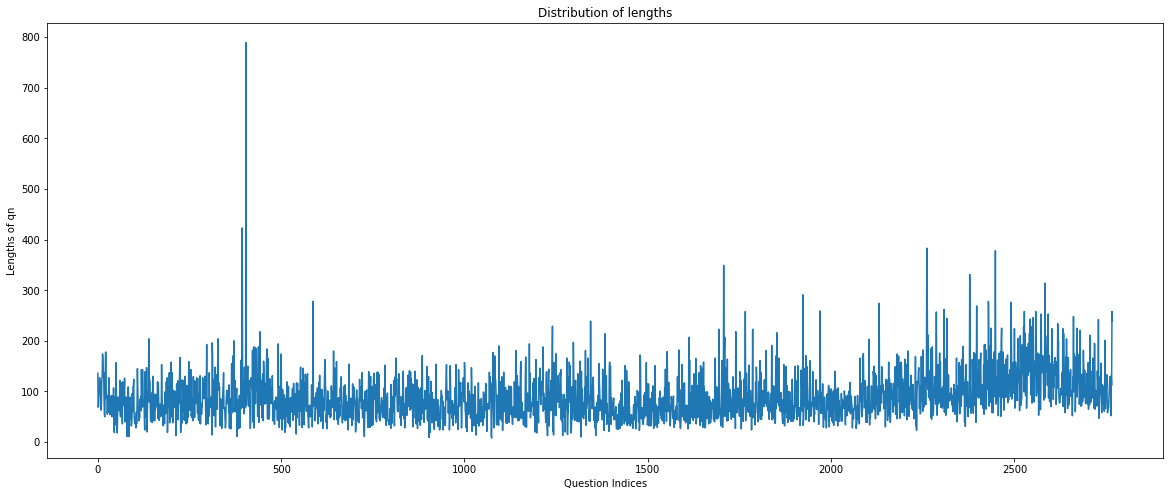

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(len_of_qns)
plt.xlabel('Question Indices')
plt.ylabel('Lengths of qn')
plt.title("Distribution of lengths")

We notice that the minimum length for a question is 2, which is definitely an outlier. <br>
Let's trim the dataset so that the minimum length is 15. 

In [ ]:
less_than_15_idx = len_of_qns[len_of_qns<15].index
qns.drop(less_than_15_idx, inplace=True)

In [ ]:
qns.reset_index(drop=True, inplace=True)

Let's look at the distribution again

Text(0.5, 1.0, 'Distribution of lengths')

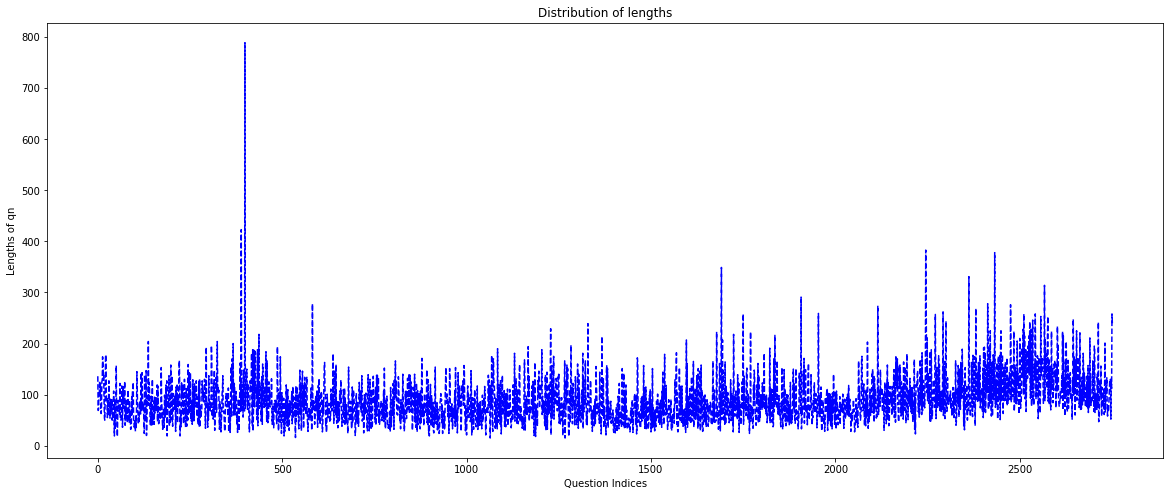

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(qns['qn'].str.split().apply(lambda qn: len(qn)), 'b--')
plt.xlabel('Question Indices')
plt.ylabel('Lengths of qn')
plt.title("Distribution of lengths")

## Modelling Process

Steps to be followed,
* `TfidfVectorizer` will be used to convert the text data into a vector representation
* `StratifiedKFold` will be used as the validation method as the distribution of classes is imbalanced
* `RandomForestClassifier and LogisticRegression` will be used in their base forms without any hyperparameter tuning, so as to understand where the models go wrong
* Metric used will be `accuracy_score` and the `confusion_matrix` will be plotted to see which classes the models misinterpret

**Note**:<br>
The models mentioned above, be it the vectorizer or the dimensionality reduction model, are all subjectable to change based on the metric score. The primary goal is to make sure that text processing pipeline gives a good numeric representation of the text to be transformed

Before carrying out the steps above, it would be prudent to group the classes to a number where each class has a good number of instances that the models can learn from

Text(0, 0.5, 'Count')

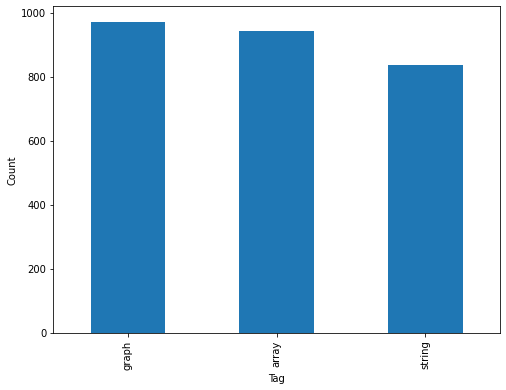

In [ ]:
fig, ax = plt.subplots(1,1)
qns['tag'].value_counts().sort_values(ascending=False).plot.bar(figsize=(8,6),
                                                                ax=ax)
ax.set_xlabel('Tag')
ax.set_ylabel('Count')

In [ ]:
classes = {key:value for value, key in enumerate(qns["tag"].unique())}
qns_sub = qns[qns["tag"].isin(classes.keys())]
qns_sub.reset_index(drop=True, inplace=True)

### Creating training and test sets

The training and test sets will have the following ratio
  * Train set - 0.90
  * Test set  - 0.10

The sets will be created in such a way that the ratio of target classes remains the same in both training and testing data. This is essential for the model to learn about the different classes equally and improves the model's generalizability<br>
In the subsequent preprocessing stages, all the preprocessing models will be trained on the training set to avoid data leakage.

In [ ]:
qns_sub['tag'].unique()

array(['graph', 'array', 'string'], dtype=object)

In [ ]:
qns_sub['tag'] = qns_sub['tag'].map(classes)

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(qns_sub['qn'], 
                                                                    qns_sub['tag'],
                                                                    test_size=TEST_SIZE,
                                                                    random_state=SEED,
                                                                    stratify=qns_sub['tag'])

In [ ]:
y_train, y_test = y_train.values, y_test.values

### Vectorizing the text data

`TfidfVectorizer` from `scikit-learn` will be used initially.<br>
Depending on the model's performance other approaches might be selected in the future

In [ ]:
vectorizer = TfidfVectorizer(max_features=VOCAB_SIZE)
vectorizer = vectorizer.fit(X_train)

In [ ]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
X_train.shape, X_test.shape

((2476, 1500), (276, 1500))

### StratifiedKFold split

In [ ]:
skf = model_selection.StratifiedKFold(n_splits=5,
                                          shuffle=True,
                                          random_state=SEED)

models = [linear_model.LogisticRegression(random_state=SEED), 
          ensemble.RandomForestClassifier(random_state=SEED), 
          xgb.XGBClassifier(random_state=SEED),]

for fold, (tr, tt) in enumerate(skf.split(X_train, y_train)): 
   
    x_tr, x_tt = X_train[tr], X_train[tt]
    y_tr, y_tt = y_train[tr], y_train[tt]

    print(f"Fold: {fold+1}")
    
    for model in models:
      model = model.fit(x_tr, y_tr)
      pred = model.predict(x_tt)
      print(f"\t{model.__class__.__name__} accuracy: {metrics.accuracy_score(y_tt, pred)}")

Fold: 1
	LogisticRegression accuracy: 0.719758064516129
	RandomForestClassifier accuracy: 0.7681451612903226
	XGBClassifier accuracy: 0.7520161290322581
Fold: 2
	LogisticRegression accuracy: 0.6767676767676768
	RandomForestClassifier accuracy: 0.7494949494949495
	XGBClassifier accuracy: 0.7434343434343434
Fold: 3
	LogisticRegression accuracy: 0.6545454545454545
	RandomForestClassifier accuracy: 0.7191919191919192
	XGBClassifier accuracy: 0.7333333333333333
Fold: 4
	LogisticRegression accuracy: 0.7292929292929293
	RandomForestClassifier accuracy: 0.7919191919191919
	XGBClassifier accuracy: 0.7757575757575758
Fold: 5
	LogisticRegression accuracy: 0.6747474747474748
	RandomForestClassifier accuracy: 0.7151515151515152
	XGBClassifier accuracy: 0.7151515151515152


### Confusion matrix

#### Helper function to visualize confusion matrix

In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  # Create the confustion matrix
  cm = metrics.confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)
  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  ax.set_xticklabels(labels, rotation=90)
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

To know where the model is struggling we need to have a validation set. <br>
Let's create a temporary validation and training set

In [ ]:
model = xgb.XGBClassifier(random_state=SEED,
                          n_estimators=1000)

X_tr, X_val, y_tr, y_val = model_selection.train_test_split(X_train, y_train,
                                                            random_state=SEED,
                                                            test_size=0.15,
                                                            stratify=y_train)

model = model.fit(X_tr, y_tr)
tr_pred = model.predict(X_tr)
val_pred = model.predict(X_val)

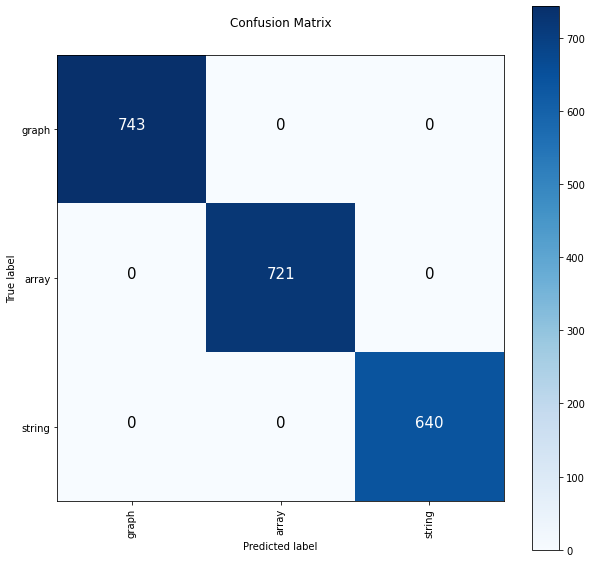

In [ ]:
make_confusion_matrix(y_tr, tr_pred, classes=list(classes.keys()))

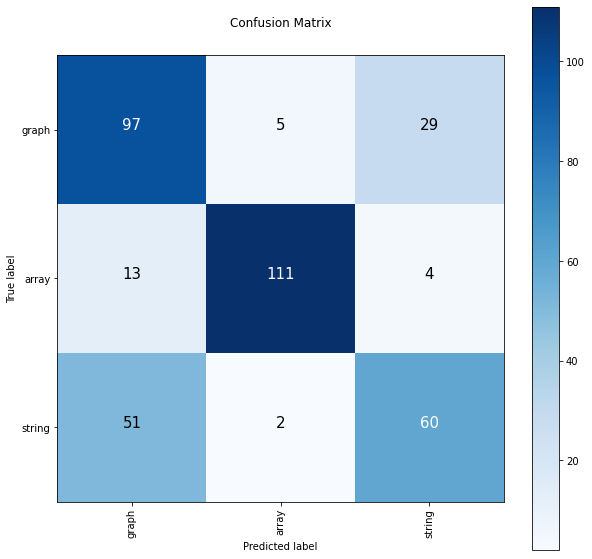

In [ ]:
make_confusion_matrix(y_val, val_pred, classes=list(classes.keys()))

In [ ]:
metrics.accuracy_score(y_val, val_pred)

0.7204301075268817

In [ ]:
metrics.accuracy_score(y_val, [0]*len(y_val))

0.3521505376344086

In [ ]:
tt_pred = model.predict(X_test)
metrics.accuracy_score(y_test, tt_pred), metrics.accuracy_score(y_test, [0]*len(y_test))

(0.7898550724637681, 0.35144927536231885)

## Transformer model - BERT

In [ ]:
!pip install transformers
!pip install datasets

In [ ]:
import transformers as T
import datasets as D

import torch
from torch import nn
import torch.nn.functional as F

CHECK_POINT = 'distilbert-base-uncased'
TRAIN_SIZE = 0.90 # of the whole dataset
VAL_SIZE = 0.1 # of the training set
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_LABELS = len(classes)
BATCH_SIZE = 64
MAX_LENGTH = int(qns_sub['qn'].str.split().apply(len).mean())

In [ ]:
X, y = qns_sub['qn'].copy(), qns_sub['tag'].copy()
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size=1-TRAIN_SIZE,
                                                                    random_state=SEED,
                                                                    stratify=y)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train,
                                                                  y_train,
                                                                  test_size=VAL_SIZE,
                                                                  random_state=SEED,
                                                                  stratify=y_train)

print(f"Train set: {X_train.shape},{y_train.shape}")
print(f"Test set:  {X_test.shape}, {y_test.shape}")
print(f"Val set:   {X_val.shape},  {y_val.shape}")

Train set: (2228,),(2228,)
Test set:  (276,), (276,)
Val set:   (248,),  (248,)


In [ ]:
bert_train = pd.DataFrame([X_train, y_train]).T
bert_test = pd.DataFrame([X_test, y_test]).T
bert_val = pd.DataFrame([X_val, y_val]).T

bert_train['tag'] = bert_train['tag'].astype('category')
bert_test['tag']  = bert_test['tag'].astype('category')
bert_val['tag']   = bert_val['tag'].astype('category')

bert_train.to_csv('bert_train.csv', index=None)
bert_test.to_csv('bert_test.csv', index=None)
bert_val.to_csv('bert_val.csv', index=None)

In [ ]:
data_files = {'train'     : 'bert_train.csv',
              'test'      : 'bert_test.csv',
              'validation': 'bert_val.csv'}

features = D.Features(
    {
        'qn'  : D.Value(dtype='string', id=None),
        'tag' : D.ClassLabel(num_classes=NUM_LABELS, names=list(classes.keys()), id=None)
    }
)

questions = D.load_dataset('csv', data_files=data_files, features=features)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-32118133982ef293/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
questions['train'].features

{'qn': Value(dtype='string', id=None),
 'tag': ClassLabel(names=['graph', 'array', 'string'], id=None)}

In [ ]:
questions = questions.rename_column('tag','label')

In [ ]:
tokenizer = T.AutoTokenizer.from_pretrained(CHECK_POINT)
model     = (T.AutoModelForSequenceClassification.from_pretrained(CHECK_POINT, 
             num_labels=NUM_LABELS).to(DEVICE))

In [ ]:
def tokenize(batch):
  return tokenizer(batch['qn'], padding=True, truncation=True,
                   max_length=30)

questions_encoded = questions.map(tokenize, batched=True, batch_size=BATCH_SIZE)

  0%|          | 0/35 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [ ]:
questions_encoded['train'].features

{'qn': Value(dtype='string', id=None),
 'label': ClassLabel(names=['graph', 'array', 'string'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [ ]:
questions_encoded.set_format('torch',
                             columns=['input_ids','attention_mask','label'])

In [ ]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  f1  = metrics.f1_score(labels, preds, average='weighted')
  acc = metrics.accuracy_score(labels, preds)

  return {'accuracy': acc, 
          'f1'      : f1}

In [ ]:
model_name = f"{CHECK_POINT}-question-tagging-1"
logging_steps = len(questions_encoded['train'])//BATCH_SIZE

training_args = T.TrainingArguments(output_dir=model_name,
                                    num_train_epochs=5,
                                    learning_rate=2e-5,
                                    per_device_train_batch_size=BATCH_SIZE,
                                    per_device_eval_batch_size=BATCH_SIZE,
                                    weight_decay=0.01,
                                    logging_steps=logging_steps,
                                    evaluation_strategy='epoch',
                                    push_to_hub=False,
                                    log_level='error',
                                    disable_tqdm=False)

trainer = T.Trainer(model=model,
                    args=training_args,
                    compute_metrics=compute_metrics,
                    train_dataset=questions_encoded['train'],
                    eval_dataset=questions_encoded['validation'],
                    tokenizer=tokenizer)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.990800,0.777643,0.681452,0.671881
2,0.717700,0.646313,0.701613,0.692945
3,0.608500,0.605272,0.725806,0.717114
4,0.570200,0.602678,0.733871,0.722499
5,0.536400,0.603536,0.737903,0.727867


TrainOutput(global_step=175, training_loss=0.6816322599138532, metrics={'train_runtime': 32.8245, 'train_samples_per_second': 339.381, 'train_steps_per_second': 5.331, 'total_flos': 86467566668400.0, 'train_loss': 0.6816322599138532, 'epoch': 5.0})

In [ ]:
preds_output = trainer.predict(questions_encoded["validation"])
preds_output.metrics

{'test_loss': 0.6035363078117371,
 'test_accuracy': 0.7379032258064516,
 'test_f1': 0.7278670712974411,
 'test_runtime': 0.2626,
 'test_samples_per_second': 944.555,
 'test_steps_per_second': 15.235}

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

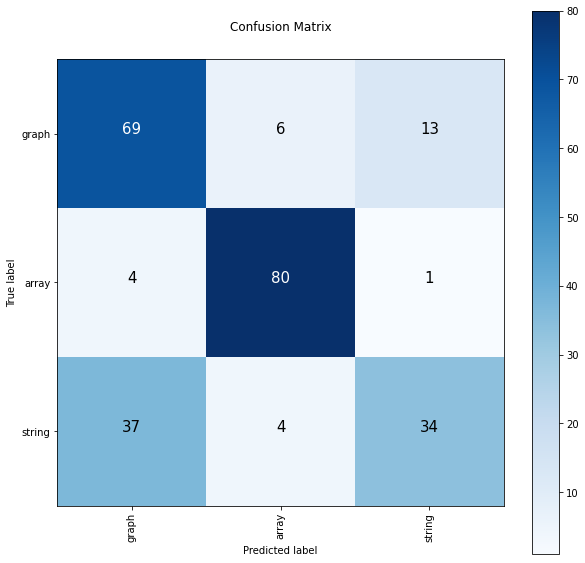

In [ ]:
make_confusion_matrix(y_val, y_preds, list(classes.keys()))

### Error Analysis

In [ ]:
from torch.nn.functional import cross_entropy

In [ ]:
def forward_pass_with_label(batch):
  inputs = {k:v.to(DEVICE) for k,v in batch.items() if k in tokenizer.model_input_names}

  with torch.no_grad():
    outputs = model(**inputs)
    pred_label = torch.argmax(outputs.logits, axis=-1)
    loss = cross_entropy(outputs.logits, batch["label"].to(DEVICE),
                         reduction="none")
  
  return {
      "loss" : loss.cpu().numpy(),
      "predicted_label" : pred_label.cpu().numpy()
  }

In [ ]:
questions_encoded.set_format("torch",
                             columns=["input_ids", "attention_mask", "label"])
questions_encoded["validation"] = questions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=BATCH_SIZE
)

  0%|          | 0/4 [00:00<?, ?ba/s]

In [ ]:
questions_encoded.set_format("pandas")
cols = ["qn", "label", "predicted_label", "loss"]

In [ ]:
def label_int2str(row):
  return questions["train"].features["label"].int2str(row)

In [ ]:
df_test = questions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = df_test["predicted_label"].apply(label_int2str)

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

,qn,label,predicted_label,loss
210,n couple sit 2n seat arrange row want hold han...,graph,array,3.964778
166,n x n grid topleft cell 0 0 bottomright cell n...,string,array,3.831321
60,give array length n weight mass a1 a2anno weig...,graph,array,3.667219
28,give tree n node numerate 0 n1 k 0 n inclusive...,array,graph,3.360800
216,alice receive set toy train bob consist train ...,string,array,2.770521
183,vacation n pupil decide excursion gather need ...,array,graph,2.513664
143,substre string contiguous subsequence string s...,graph,string,2.472447
195,stream n idkey value pair arrive arbitrary ord...,array,string,2.442176
141,give stre length n consist lowercase latin let...,graph,string,2.397111
115,string b subsequence string b obtain deletion ...,graph,string,2.327988
